### Dynamic quantization

In [ ]:
!pip install ultralytics torch torchvision onnx onnxruntime opencv-python numpy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from ultralytics import YOLO
model_path = "/content/drive/MyDrive/results_fire/yolov8n_100_16_640_2024-09-26_enhanced_plus/yolov8n_100_16_640_2024-09-26_enhanced_plus/weights/best.pt"
model = YOLO(model_path)
model.export(format = 'onnx')

Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/results_fire/yolov8n_100_16_640_2024-09-26_enhanced_plus/yolov8n_100_16_640_2024-09-26_enhanced_plus/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim==0.1.34', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 204.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 222.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 165.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 228.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.4s, installed 3 packages: ['o

'/content/drive/MyDrive/results_fire/yolov8n_100_16_640_2024-09-26_enhanced_plus/yolov8n_100_16_640_2024-09-26_enhanced_plus/weights/best.onnx'

In [ ]:
!python -m onnxruntime.quantization.preprocess --input yolov8n_enhanced_plus_plus.onnx --output preprocessed.onnx

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = 'preprocessed.onnx'
model_int8 = 'yolov8n_enhanced_plus_plus_dynamic_quantized.onnx'

# Quantize
quantize_dynamic(model_fp32, model_int8, weight_type=QuantType.QUInt8)

### TEST


In [ ]:
import time
import torch
from ultralytics import YOLO
import cv2
import numpy as np


In [ ]:
model_onnx = "/content/drive/MyDrive/results_fire/yolov8n_100_16_640_2024-09-26_enhanced_plus/yolov8n_100_16_640_2024-09-26_enhanced_plus/weights/yolov8n_enhanced_plus_plus_dynamic_quantized.onnx"

Image

In [ ]:
image_path = '/content/drive/MyDrive/dataset/test_images/test1.jpg'  # Remplacez par le chemin vers votre image
image = cv2.imread(image_path)

image_resized = cv2.resize(image, (640, 640))

Model original

In [ ]:
model_pt = YOLO(model_path)


In [ ]:
num_runs = 100
total_time_pt = 0

model_pt.model.eval()

with torch.no_grad():
    for _ in range(num_runs):
        start_time = time.time()
        # Exécuter l'inférence
        results = model_pt(image_resized)
        end_time = time.time()
        total_time_pt += (end_time - start_time)



0: 640x640 1 fire, 223.8ms
Speed: 6.0ms preprocess, 223.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fire, 215.1ms
Speed: 5.7ms preprocess, 215.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fire, 205.6ms
Speed: 3.9ms preprocess, 205.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fire, 194.7ms
Speed: 5.3ms preprocess, 194.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fire, 201.8ms
Speed: 5.6ms preprocess, 201.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fire, 198.7ms
Speed: 4.1ms preprocess, 198.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fire, 219.2ms
Speed: 9.3ms preprocess, 219.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 fire, 192.4ms
Speed: 4.7ms preprocess, 192.4ms inference, 1.1ms postprocess per image at shape (1, 3, 64

In [ ]:
# temps moyen d'inférence
average_time_pt = (total_time_pt / num_runs) * 1000  # Convertir en millisecondes
print(f"Temps moyen d'inférence du modèle .pt : {average_time_pt:.2f} ms")

Temps moyen d'inférence du modèle .pt : 250.88 ms


Onnx model

In [ ]:
import onnxruntime as ort
model_onnx = "/content/drive/MyDrive/results_fire/yolov8n_100_16_640_2024-09-26_enhanced_plus/yolov8n_100_16_640_2024-09-26_enhanced_plus/weights/yolov8n_enhanced_plus_plus_dynamic_quantized.onnx"
# Charger le modèle ONNX quantifié
ort_session = ort.InferenceSession(model_onnx)

In [ ]:
# Prétraiter l'image de la même manière que pour le modèle .pt
# Convertir l'image en RGB
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

# Convertir en tableau numpy et normaliser les pixels
input_image = image_rgb.astype(np.float32) / 255.0

# Transposer les dimensions pour qu'elles correspondent au format [batch_size, channels, height, width]
input_image = np.transpose(input_image, (2, 0, 1))

# Ajouter une dimension batch
input_image = np.expand_dims(input_image, axis=0)


In [ ]:
# Nombre de fois que nous allons exécuter l'inférence pour calculer le temps moyen
num_runs = 100
total_time_onnx = 0

for _ in range(num_runs):
    start_time = time.time()
    # Exécuter l'inférence
    outputs = ort_session.run(None, {'images': input_image})
    end_time = time.time()
    total_time_onnx += (end_time - start_time)

# Calculer le temps moyen d'inférence
average_time_onnx = (total_time_onnx / num_runs) * 1000  # Convertir en millisecondes
print(f"Temps moyen d'inférence du modèle quantifié ONNX : {average_time_onnx:.2f} ms")


Temps moyen d'inférence du modèle quantifié ONNX : 218.48 ms


Résultat

In [ ]:
print(f"Temps moyen d'inférence du modèle .pt : {average_time_pt:.2f} ms")
print(f"Temps moyen d'inférence du modèle quantifié ONNX : {average_time_onnx:.2f} ms")

gain_percentage = ((average_time_pt - average_time_onnx) / average_time_pt) * 100
print(f"Gain de performance : {gain_percentage:.2f}%")


Temps moyen d'inférence du modèle .pt : 250.88 ms
Temps moyen d'inférence du modèle quantifié ONNX : 218.48 ms
Gain de performance : 12.92%


### Inférence ONNX

In [ ]:
import matplotlib.pyplot as plt

def show(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)# Converts the frame to matplotlib format
    fig, ax = plt.subplots(figsize=(20, 12)) # larger fig size for better visuals
    plt.imshow(frame) # displaying the frame

In [ ]:
def preprocessor(frame):
    x = cv2.resize(frame, (640, 640))
    image_data = np.array(x).astype(np.float32) / 255.0  # Normalize to [0, 1] range
    image_data = np.transpose(image_data, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    image_data = np.expand_dims(image_data, axis=0)  # Add batch dimension
    return image_data

In [ ]:

class Inference:
    def __init__(self, model, path):
        self.session = onnxruntime.InferenceSession(model, providers=["CPUExecutionProvider"])
        model_inputs = self.session.get_inputs()
        input_shape = model_inputs[0].shape
        self.path = path
        self.input_width = input_shape[2]
        self.input_height = input_shape[3]
        self.classes = {0: 'feu', 1: 'fumee'}

    def detector(self, image_data):
        ort = onnxruntime.OrtValue.ortvalue_from_numpy(image_data)
        return self.session.run(["output0"], {"images": ort})

    def draw_detections(self, img, box, score, class_id):
        x1, y1, w, h = box
        color = (0, 255, 0)
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)
        label = f'{self.classes[class_id]}: {score:.2f}'
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                      cv2.FILLED)
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        return img

    def postprocessor(self, results, frame, confidence, iou):
        img_height, img_width = frame.shape[:2]
        outputs = np.transpose(np.squeeze(results[0]))
        rows = outputs.shape[0]
        boxes = []
        scores = []
        class_ids = []
        x_factor = img_width / self.input_width  # img_width = 640
        y_factor = img_height / self.input_height  # img_width = 640
        for i in range(rows):

            classes_scores = outputs[i][4:]
            max_score = np.max(classes_scores)
            if max_score >= confidence:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)
                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]
                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) * x_factor)
                top = int((y - h / 2) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)

                class_ids.append(class_id)
                scores.append(max_score)
                boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, confidence, iou)

        for idx in indices:
            i = idx[0] if isinstance(idx, (list, tuple, np.ndarray)) else idx
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]
            frame = self.draw_detections(frame, box, score, class_id)
        return frame

    def pipeline(self):
        frame = cv2.imread(self.path)
        frame = self.postprocessor(self.detector(preprocessor(frame)), frame, 0.35, 0.35)
        return frame

Model quantifié dynamiquement

False

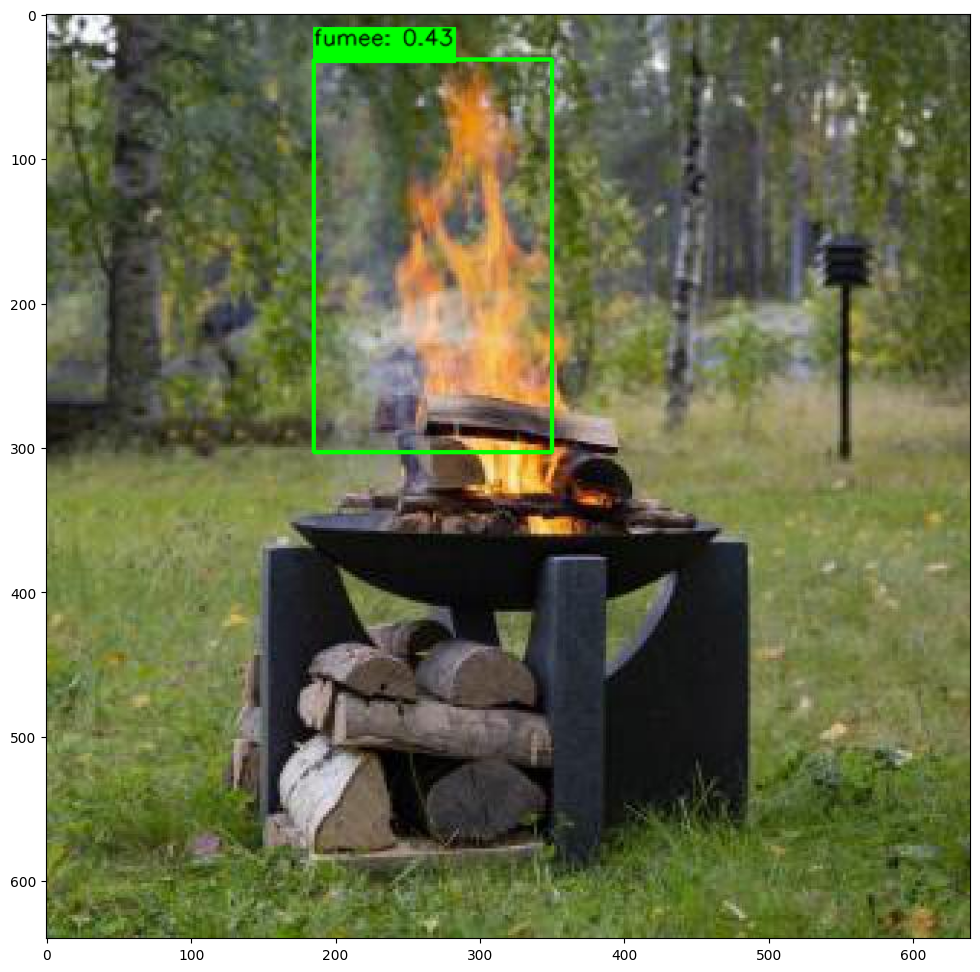

In [ ]:
x = Inference(model_onnx, image_path)
y = x.pipeline()
show(y)
cv2.imwrite('results/static_quantized.jpg', y)

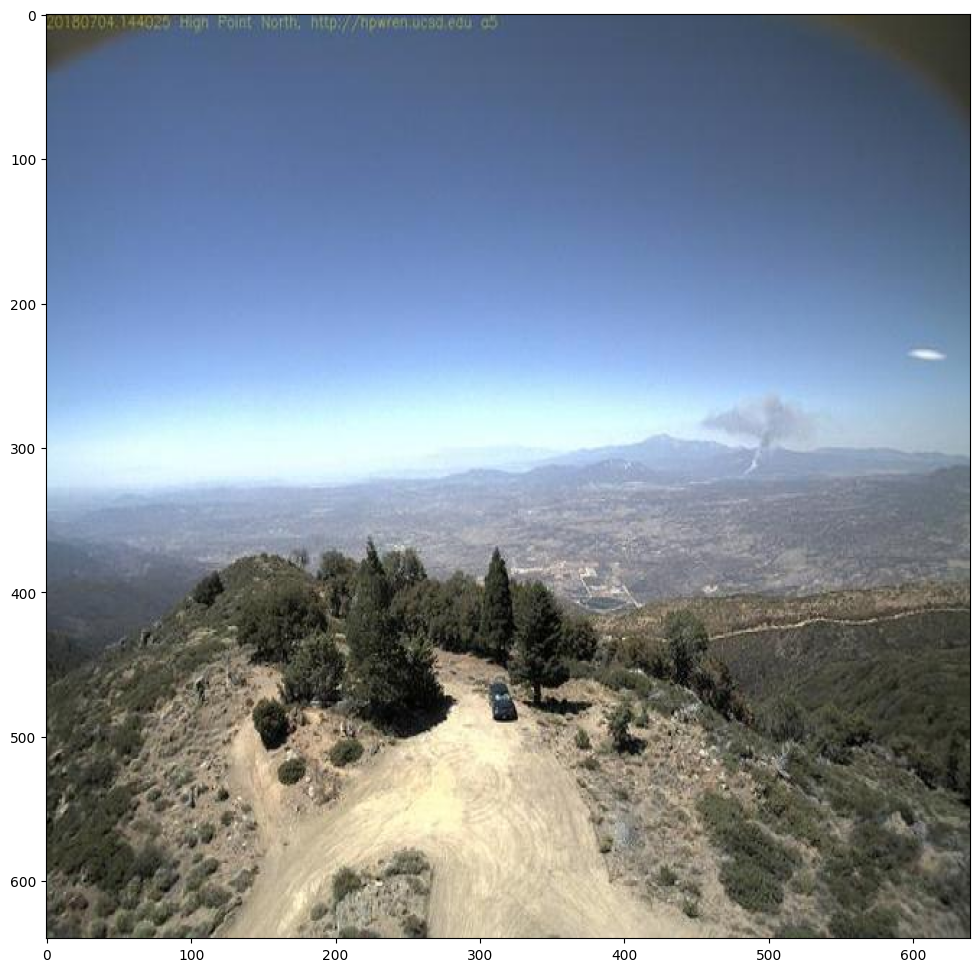

In [ ]:
image_path2 = '/content/drive/MyDrive/dataset/test_images/test2.jpg'
x = Inference(model_onnx, image_path2)
y = x.pipeline()
show(y)

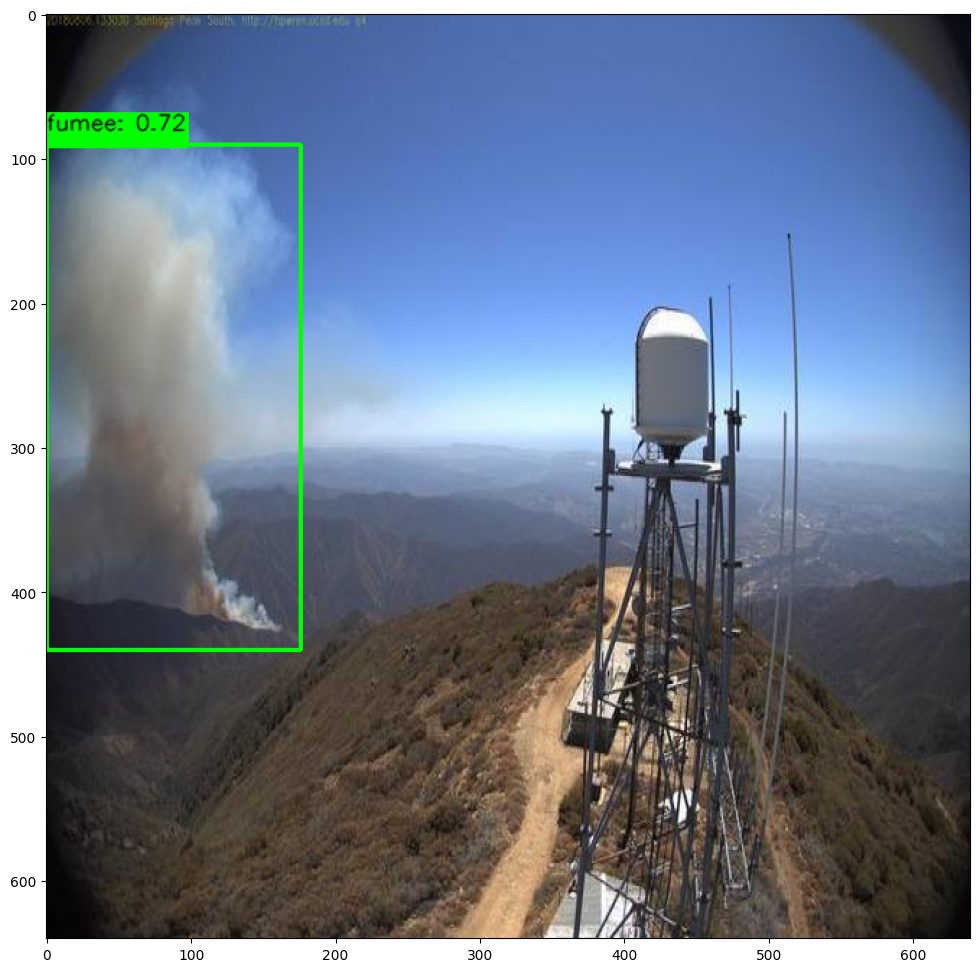

In [ ]:
image_path3 = '/content/drive/MyDrive/dataset/test_images/test3.jpg'
x = Inference(model_onnx, image_path3)
y = x.pipeline()
show(y)

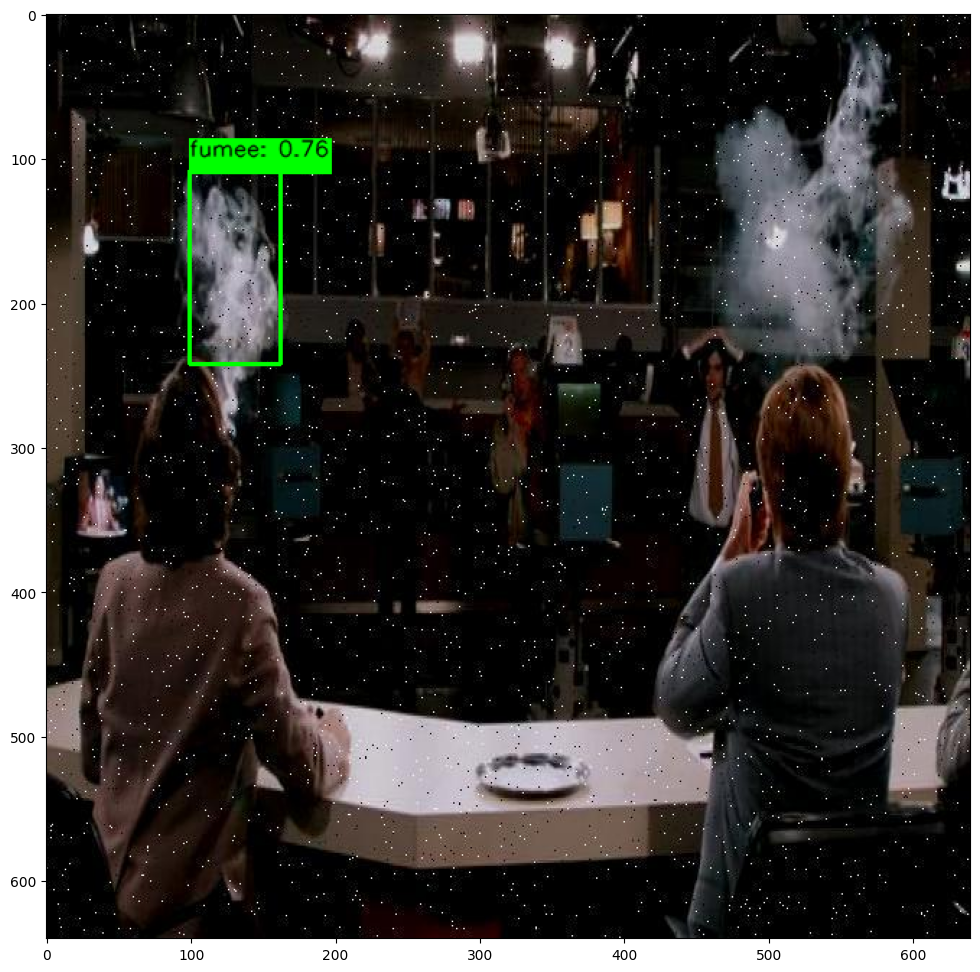

In [ ]:
image_path4 = '/content/drive/MyDrive/dataset/test_images/test4.jpg'
x = Inference(model_onnx, image_path4)
y = x.pipeline()
show(y)

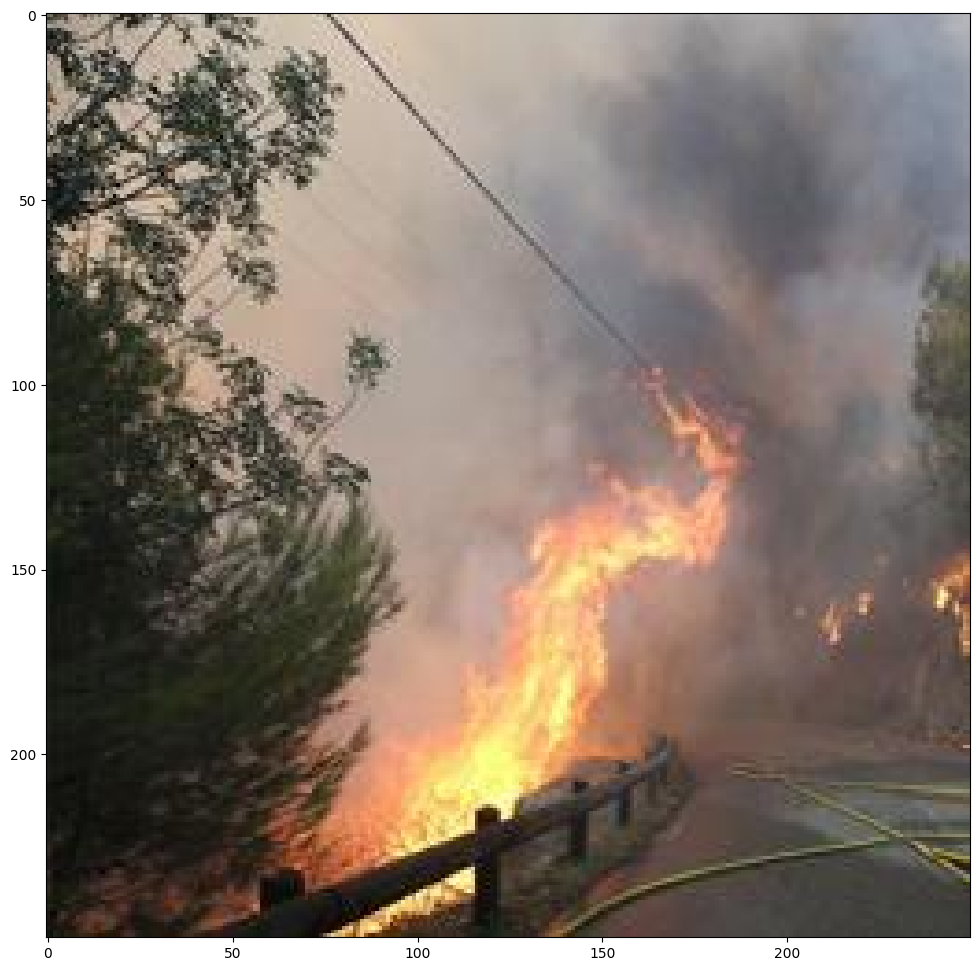

In [ ]:
image_path5 = '/content/drive/MyDrive/dataset/test_images/test5.jpg'
x = Inference(model_onnx, image_path5)
y = x.pipeline()
show(y)

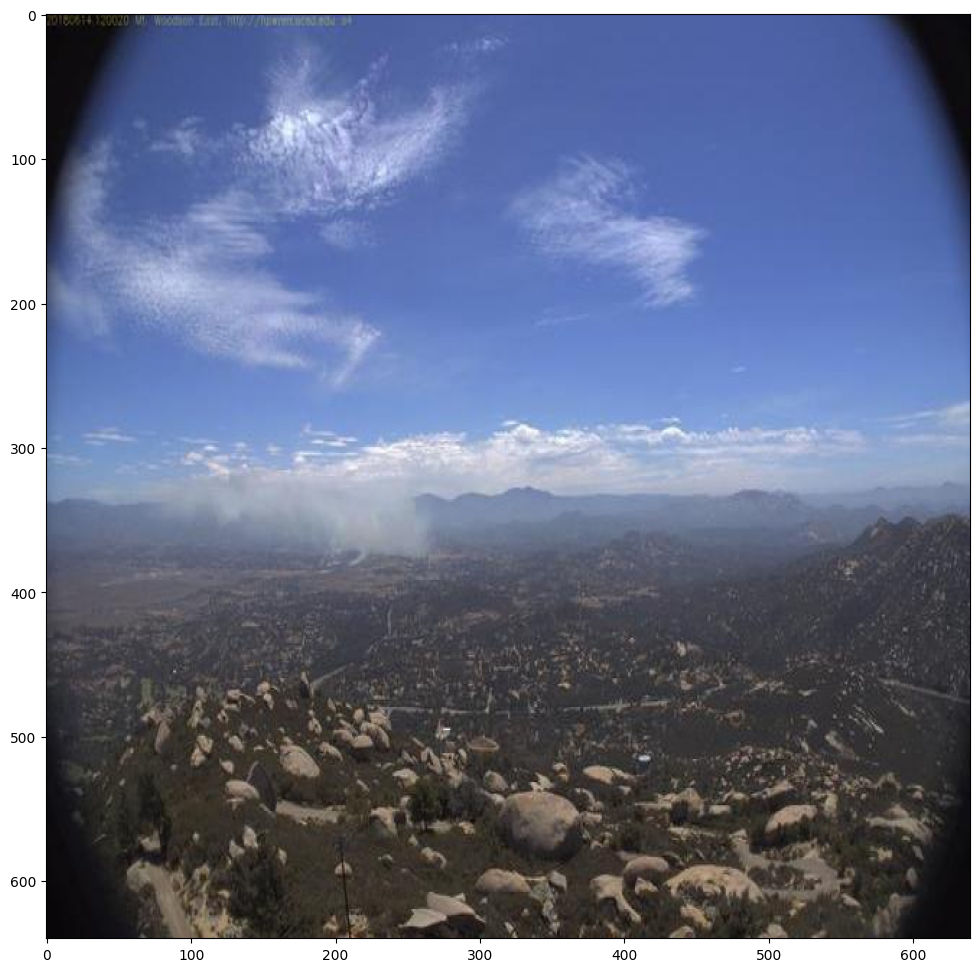

In [ ]:
image_path6 = '/content/drive/MyDrive/dataset/test_images/test7.jpg'
x = Inference(model_onnx, image_path6)
y = x.pipeline()
show(y)

Model non quantifié dynamiquement

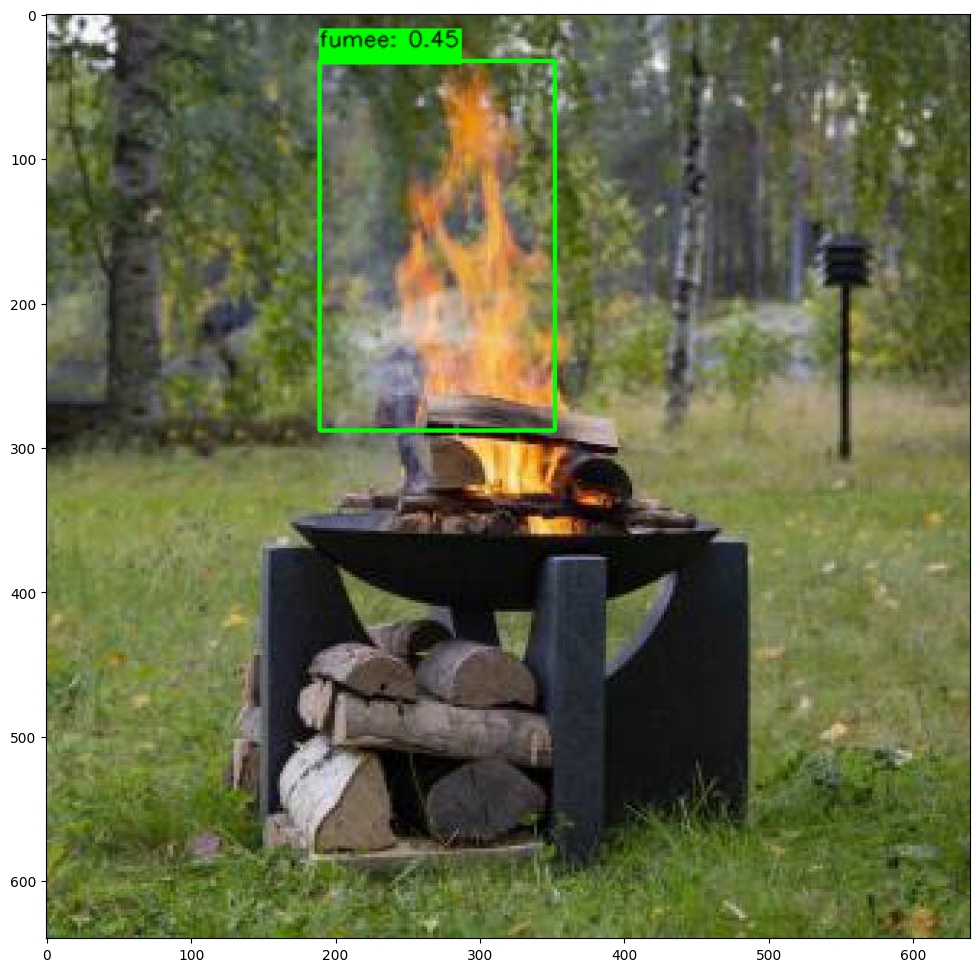

In [ ]:
model_unquantization = "/content/yolov8n_enhanced_plus_plus.onnx"
x = Inference(model_unquantization, image_path)
y = x.pipeline()
show(y)

Model original

In [ ]:
image_path = '/content/drive/MyDrive/dataset/test_images/test5.jpg'  # Remplacez par le chemin vers votre image
image = cv2.imread(image_path)
image_resized = cv2.resize(image, (640, 640))


0: 640x640 3 fires, 1 smoke, 193.5ms
Speed: 6.2ms preprocess, 193.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Predict
smoke: 0.54
Predict
fire: 0.49
Predict
fire: 0.43
Predict
fire: 0.30


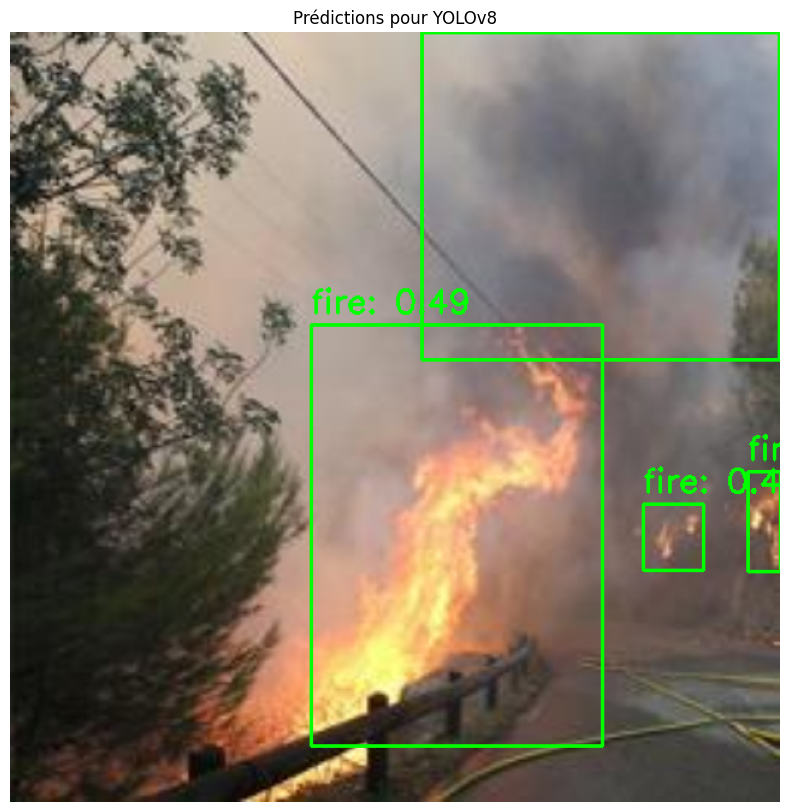

In [ ]:
results = model_pt(image_resized)
for result in results:

            boxes = result.boxes  # Boîtes de délimitation
            if boxes is not None:
                for box in boxes:
                    print("Predict")
                    x1, y1, x2, y2 = box.xyxy[0]  # Coordonnées des coins
                    conf = box.conf[0]  # Confiance
                    if conf >= 0.3:  # Appliquer un seuil de confiance
                        cls = box.cls[0]  # Classe de l'objet détecté
                        label = f"{model.names[int(cls)]}: {conf:.2f}"
                        print(label)
                        cv2.rectangle(image_resized, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                        cv2.putText(image_resized, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Prédictions pour YOLOv8')
            plt.show()